In [ ]:
# !pip install pyabc --quiet

# # mount drive, only need to be done once
# from google.colab import drive
# drive.mount('/content/gdrive')

# %cd /content/gdrive/MyDrive/colab/H0vABC/

We use the ABC algorithm to give insight about $H_0$ in view of the Hubble tension and late time data sets. First off, we import the usual python science packages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.constants import c
from scipy.integrate import quad

# for the analytic LambdaCDM growth rate
from scipy.special import hyp2f1

# for the WiggleZ covariance in the growth data
from scipy.linalg import block_diag

import os
import tempfile

import pyabc
from pyabc import Distribution, RV
from pyabc import ABCSMC, History
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.visualization import plot_kde_1d

plt.rcParams['text.usetex'] = True

### Data sets

We import the data sets to be considered in this study. We start with the Hubble expansion data coming from cosmic chronometers and baryon acoustic oscillations. These are direct measurements of the expansion rate and are given below.

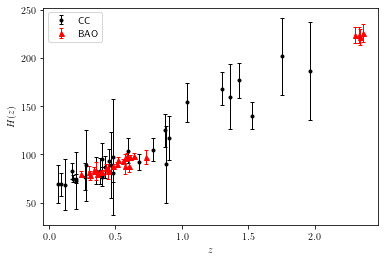

In [ ]:
# load CC and BAO expansion rate data
cc_loc = 'https://raw.githubusercontent.com/reggiebernardo/\
datasets/main/Hdz_2020_CConly.txt'
# cc_loc = '../../datasets/Hdz_2020_CConly.txt'
cc_data = np.loadtxt(cc_loc)

z_cc = cc_data[:, 0]
Hz_cc = cc_data[:, 1]
sigHz_cc = cc_data[:, 2]

bao_loc = 'https://raw.githubusercontent.com/reggiebernardo/\
datasets/main/Hdz_2020_BAOonly.txt'
# bao_loc = '../../datasets/Hdz_2020_BAOonly.txt'
bao_data = np.loadtxt(bao_loc)

z_bao = bao_data[:, 0]
Hz_bao = bao_data[:, 1]
sigHz_bao = bao_data[:, 2]

fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'ko', ecolor = 'k', \
            markersize = 3, elinewidth = 1, capsize = 2, label = 'CC')
ax.errorbar(z_bao, Hz_bao, yerr = sigHz_bao, fmt = 'r^', ecolor = 'r', \
            markersize = 5, elinewidth = 1, capsize = 2, label = 'BAO')

ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
ax.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

We consider the Pantheon+ supernovae data set. This consists of 1701 supernovae observations and provides a measurement of the SNe apparent magnitudes.

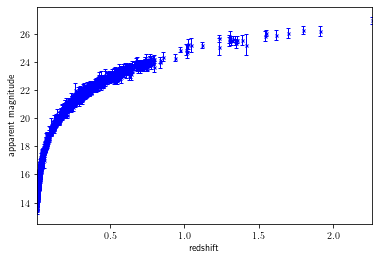

In [ ]:
loc_lcparam = 'https://github.com/PantheonPlusSH0ES/DataRelease/raw/main/\
Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat'

# loc_lcparam = '../../datasets/pantheon2/Pantheon+SH0ES.dat'

# pantheon plus systematics

lcparam = np.loadtxt(loc_lcparam, skiprows = 1, usecols = (2, 8, 9, 10, 11))

# setup pantheon samples
z_pp = lcparam[:, 0][111:]
mz_pp = lcparam[:, 1][111:]
sigmz_pp = lcparam[:, 2][111:]

mMz_pp = lcparam[:, 3][111:]
sigmMz_pp = lcparam[:, 4][111:]

# apparent magnitudes
plt.errorbar(z_pp, mz_pp, yerr = sigmz_pp,
             fmt = 'bx', markersize = 3,
             ecolor = 'blue', elinewidth = 1, capsize = 2)
plt.xlim(min(z_pp), max(z_pp))
plt.xlabel('redshift')
plt.ylabel('apparent magnitude')
plt.show()

The covariance matrix of the Pantheon+ data is also imported below.

In [ ]:
# load the pantheon+ covariance matrix

loc_lcparam_sys = 'https://raw.githubusercontent.com/PantheonPlusSH0ES/\
DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov'

# loc_lcparam_sys = '../../datasets/pantheon2/Pantheon+SH0ES_STAT+SYS.cov'
lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)

# pantheon plus systematics
cov = lcparam_sys.reshape(1701, 1701)
cov_inv = np.linalg.inv(cov[111:, 111:])

We also consider the growth rate data from redshift space distorsion measurements.

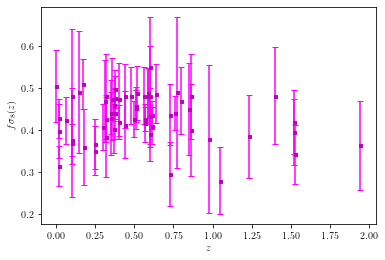

In [ ]:
# load growth RSD data
# loc_rsd = '../../datasets/growth_1803.01337/Growth_tableII.txt'
loc_rsd = 'https://raw.githubusercontent.com/reggiebernardo/\
datasets/main/Growth_tableII.txt'
rsd = np.loadtxt(loc_rsd, usecols = (0, 1, 2))

# the WiggleZ points (3x3) covariance
# wgz_loc = '../../datasets/growth_1803.01337/Cij_WiggleZ.txt'
wgz_loc = 'https://raw.githubusercontent.com/reggiebernardo/\
datasets/main/Cij_WiggleZ.txt'
C_wgz = np.loadtxt(wgz_loc)

# setup
z_rsd = rsd[:, 0]
fs8_rsd = rsd[:, 1]
sigfs8_rsd = rsd[:, 2]

fig, ax = plt.subplots()
ax.errorbar(z_rsd, fs8_rsd, yerr = sigfs8_rsd, fmt = 'ms', \
            ecolor = 'magenta', markersize = 3, elinewidth = 1.5, capsize = 3)
ax.set_xlabel('$z$')
ax.set_ylabel('$f \sigma_8(z)$')
plt.show()

# f*sigma_8 data covariance with WiggleZ
C_rsd_1 = np.diag(sigfs8_rsd[: 9]**2)
C_rsd_w = C_wgz
C_rsd_N = np.diag(sigfs8_rsd[12:]**2)

C_rsd = block_diag(C_rsd_1, C_rsd_w, C_rsd_N)
C_rsd_inv = np.linalg.inv(C_rsd)

### $\Lambda$CDM cosmology

We code the predictions of the standard $\Lambda$CDM cosmological model on the expansion rate, supernovae brightness, and growth rate that we can compare with observations.

The output of this section are:

(1) model for the expansion rate $H(z)$;

(2) model for the SNe apparent magnitudes $m(z)$;

(3) model for growth rate $f\sigma_8(z)$;

(4) chi-squared measure: $\chi^2 \left( H_0, \Omega_{m0}, \sigma_{8}, M \right) = \chi^2_\text{CC} + \chi^2_\text{BAO} + \chi^2_\text{SNe} + \chi^2_\text{RSD}$.

In [ ]:
# expansion rate

def E(z, Om):
    Or = 0
    Ol = 1-Or-Om
    return np.sqrt(Om*(1+z)**3+Or*(1+z)**4+Ol)

# supernovae brightness

def E_inv(z, Om):
    return 1/E(z, Om)
  
def dL(z, Om, H0):
    rz = quad(E_inv, 0, z, args=(Om,))[0]
    return (1+z)*c/(H0)*rz

# SNe distance modulus

def mu(z, Om, H0):     
    return 5*np.log10(dL(z,Om,H0)*100)

# growth rate

def dltz(z, Om):
    '''analytic LambdaCDM density contrast \delta(z)'''
    a = 1/(1 + z)
    return a*hyp2f1(1/3, 1, 11/6, (a**3)*(1 - (1/Om)))

def dltpz(z, Om):
    '''analytic LambdaCDM \delta'(z)'''
    a = 1/(1 + z)
    dadz = -1/((1 + z)**2)
    term_1 = -2*hyp2f1(1/3, 1, 11/6, (a**3)*(1 - (1/Om)))
    term_2 = 3*hyp2f1(1/3, 2, 11/6, (a**3)*(1 - (1/Om)))
    return (term_1 + term_2)*dadz

def fs8(z, Om, s80):
    dlt0 = dltz(0, Om)
    return -(1 + z)*s80*dltpz(z, Om)/dlt0

# chi-squared measures

def Chi_CC(Om, H0):
    return sum(((Hz_cc-H0*E(z_cc, Om))**2)/sigHz_cc**2)

def Chi_BAO(Om, H0):
    return sum(((Hz_bao-H0*E(z_bao, Om))**2)/sigHz_bao**2)

def Chi_SN(Om, H0, M):
    m_th = np.array([mu(z, Om, H0)+M for z in z_pp])
    m = mz_pp
    dm = m - m_th  
    return dm.T@cov_inv@dm

def Chi_RSD(Om, s80):
    '''chi-squared for f*sigma_8(z) observations'''
    fs8_sol = fs8(z_rsd, Om, s80)
    Delta_fs8 = fs8_sol - fs8_rsd
    chi2 = Delta_fs8.T @ C_rsd_inv @ Delta_fs8
    return chi2

# testing the model Om = 0.3, H0 = 72, fs8 = 0.8, M = -19.3
H0_test, Om_test, s80_test = 72, 0.3, 0.8
chi_CC = Chi_CC(Om_test, H0_test)
chi_BAO = Chi_BAO(Om_test, H0_test)
chi_SN = Chi_SN(Om_test, H0_test, -19.3)
chi_RSD = Chi_RSD(Om_test, s80_test)

print("check_chi2:", chi_CC + chi_BAO + chi_SN + chi_RSD, \
      '=', chi_CC, '+', chi_BAO, '+', chi_SN, '+', chi_RSD)

check_chi2: 1564.3720896363495 = 18.110259739697955 + 100.73646901793357 + 1406.6712079833324 + 38.854152895385695


We will reproduce this number later as we consider the chi-squared for the distance function in the ABC algorithm.

### $\Lambda$CDM + ABC: Which $H_0$ survives naturally?

We study the $\Lambda$CDM model together with the ABC method to let the late time data choose which $H_0$ prior it prefers.

Output:

(1) specify the distance function ($\chi^2$) of model_1[Planck $H_0$] and model_2[SH0ES $H_0$];

(2) obtain the joint model posterior per generation;

(3) estimate the cosmological parameters, that is, $\left(H_0, \Omega_{m0}\right)$ of the ABC selected model.

We write down the model for input to ABC. This returns the predictions of the expansion rate and supernovae brightness on the observation redshifts.

In [ ]:
class Modelc:    
    __name__ = 'LambdaCDM'

    def __init__(self, H0_prior): # the H0_prior is only a label
        self.H0_prior = H0_prior  #   we use the same model for both
        
    def __call__(self, par):
        m_arr = np.array([mu(z, par['Om'], par['H0']) - par['M'] for z in z_pp])
        preds = {"Hz1": par['H0']*E(z_cc, par['Om']), \
                 "Hz2": par['H0']*E(z_bao, par['Om']), \
                 "m": m_arr, \
                 "fs8": fs8(z_rsd, par["Om"], par["s80"])}
        return preds

# test this works for a fiducial H0 = 72, Om = 0.3, fs8 = 0.8, M = -19.3
oa = Modelc('P18')
oa({'H0': 72, 'Om': 0.3, 'M': 19.3, 's80': 0.8})

{'Hz1': array([ 74.39077143,  75.11876664,  76.24791161,  78.22805467,
         78.60153358,  79.44485772,  79.47443362,  82.54965319,
         83.00777548,  86.43699298,  87.85075336,  88.86095205,
         88.88153732,  90.14515113,  91.47174089,  92.56850744,
         93.02194185,  93.11517018,  99.57144674, 104.87629062,
        111.43380661, 117.8427974 , 118.16342029, 119.5655335 ,
        129.51355909, 150.16963208, 155.39885021, 161.07209618,
        169.74728154, 189.6631224 , 210.15854825]),
 'Hz2': array([ 81.20333518,  83.93791992,  84.40989944,  85.85320577,
         86.34335643,  86.83799382,  87.84063737,  88.86095205,
         90.42414902,  90.95384718,  90.95384718,  93.11517018,
         94.78015296,  95.34339936,  97.63701226,  98.22045405,
         98.22045405,  99.39921922,  99.99449585, 100.59367083,
        102.41435499, 108.07953312, 243.96315787, 247.09547293,
        248.14328857, 250.24445786]),
 'm': array([13.84887992, 13.85103272, 13.85103272, ..., 26.3172

The model and parameter priors are input below.

In [ ]:
# models
models = [Modelc('P18'), Modelc('R22')]

# priors
p1 = Distribution(H0 = RV("norm", 67.4, 0.5), Om = RV("uniform", 0.20, 0.40), \
                  s80 = RV("norm", 0.1, 1.2), M = RV("uniform", 19.0, 19.6))
p2 = Distribution(H0 = RV("norm", 73.30, 1.04), Om = RV("uniform", 0.20, 0.40), \
                  s80 = RV("norm", 0.1, 1.2), M = RV("uniform", 19.0, 19.6))
priors = [p1, p2]

Then, we code below the distance function which is the chi-squared measure.

In [ ]:
# observation
obs = {"Hz1": Hz_cc, "Hz2": Hz_bao, "m": mz_pp, "fs8": fs8_rsd}
N_obs = sum([len(z_cc), len(z_bao), len(z_pp), len(z_rsd)]) # observation size

# distance function
def distance(x, y):
    chi2_cc = sum(((x['Hz1'] - y['Hz1'])**2)/sigHz_cc**2)
    chi2_bao = sum(((x['Hz2'] - y['Hz2'])**2)/sigHz_bao**2)
    xy = x['m'] - y['m']
    chi2_sn = xy.T @ cov_inv @ xy
    Dfs8 = x['fs8'] - y['fs8']
    chi2_rsd = Dfs8.T @ C_rsd_inv @ Dfs8
    chi2_tot = chi2_cc + chi2_sn + chi2_bao + chi2_rsd
    return chi2_tot/N_obs

# distance of H0 = 72, Om = 0.3, fs8 = 0.8, and M = -19.3
dtest = distance(Modelc('P18')({"H0": 72, "Om": 0.3, "s80": 0.8, "M": 19.3}), obs)
print('bare chi2 =', dtest*N_obs)
print('distance =', dtest)

bare chi2 = 1564.3720896363495
distance = 0.9148374793195027


We setup the initial population and population parameters as adaptive.

In [ ]:
# adaptive population size
pop_size = AdaptivePopulationSize(300, mean_cv = 0.12)

Finally, we put in all these together and prepare to run the ABCSMC.

In [ ]:
abc = pyabc.ABCSMC(models, priors, distance, population_size = pop_size)

# store the results
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "H0vABC_SNeCCBAORSD_zred.db")

# # to start a new run; otherwise, check out next lines to continue previous runs
history = abc.new(db_path, obs)

ABC.Sampler INFO: Parallelize sampling on 20 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2022-11-15 15:55:00>


Stored runs can be loaded using the following commands.

In [ ]:
# stored so far

# id = 1, mean_cv = 0.12

# # if there are previous runs to check: history checking

# to specify an id
# history = pyabc.History(db_path, _id = 2)
# print('n_pop =', history.n_populations)

# defaults to latest/largest id in the database
# history = pyabc.History(db_path)
# print('id = ', history.id)
# print('n_pop =', history.n_populations)

In [ ]:
# # run to continue previous sampling

# abc_continued = pyabc.ABCSMC(models, priors, distance, \
#                              population_size = pop_size)
# run_id = 1 # specify id of previous run
# abc_continued.load(db_path, run_id)

In [ ]:
# history_continued = abc_continued.run(minimum_epsilon = 0.5, \
#                                       max_nr_populations = 4)

In [ ]:
# set history
# history = history_continued # if loading previous run

We run the ABCSMC algorithm in what follows and analyze the result.

In [ ]:
# # run the ABC until either criterion is met
history = abc.run(minimum_epsilon = 0.5, max_nr_populations = 20)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.24919431e+03.
ABC INFO: Accepted: 300 / 580 = 5.1724e-01, ESS: 3.0000e+02.
ABC.Adaptation INFO: Change nr particles 300 -> 12337
ABC INFO: t: 1, eps: 1.08603679e+03.
ABC INFO: Accepted: 12337 / 24868 = 4.9610e-01, ESS: 7.8704e+03.
ABC.Adaptation INFO: Change nr particles 12337 -> 29643
ABC INFO: t: 2, eps: 2.44180650e+02.
ABC INFO: Accepted: 29643 / 62087 = 4.7744e-01, ESS: 2.5304e+04.
ABC.Adaptation INFO: Change nr particles 29643 -> 32869
ABC INFO: t: 3, eps: 5.15977482e+01.
ABC INFO: Accepted: 32869 / 68322 = 4.8109e-01, ESS: 2.9773e+04.
ABC.Adaptation INFO: Change nr particles 32869 -> 31697
ABC INFO: t: 4, eps: 1.46664768e+01.
ABC INFO: Accepted: 31697 / 66781 = 4.7464e-01, ESS: 2.8830e+04.
ABC.Adaptation INFO: Change nr particles 31697 -> 27925
ABC INFO: t: 5, eps: 6.44777805e+00.
ABC INFO: Accepted: 27925 / 56143 = 4.9739e-01, ESS: 2.6373e+04.
ABC.Adaptation INFO: Change nr particles 27925 -> 26645
ABC INFO: t: 6, eps: 

We view the joint model posterior below.

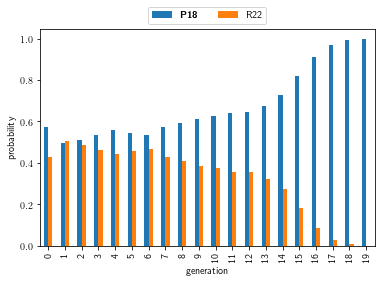

In [ ]:
ax = history.get_model_probabilities().plot.bar();
ax.set_ylabel("probability");
ax.set_xlabel("generation");
ax.legend([r'\textbf{P18}', 'R22'], ncol = 4, \
          loc = "lower center", bbox_to_anchor = (.5, 1));

We calculate the best fit parameters resulting in both models.

In [ ]:
H0_pris = ['P18', 'R22']

last_pop = {}
n_gen = history.n_populations
for m in np.arange(0, len(models)):
    t = n_gen - 1
    df, w = history.get_distribution(m = m, t = t)
    while df.empty == True:
        t -= 1
        df, w = history.get_distribution(m = m, t = t)
    df_arr = df.to_numpy()
    H0_abc, sigH0_abc = np.mean(df_arr[:, 0]), np.std(df_arr[:, 0])
    M_abc, sigM_abc = np.mean(df_arr[:, 1]), np.std(df_arr[:, 1])
    Om_abc, sigOm_abc = np.mean(df_arr[:, 2]), np.std(df_arr[:, 2])
    s80_abc, sigs80_abc = np.mean(df_arr[:, 3]), np.std(df_arr[:, 3])
    print(H0_pris[m])
    print('H0 = ', H0_abc, '+/-', sigH0_abc)
    print('Om = ', Om_abc, '+/-', sigOm_abc)
    print('s80 = ', s80_abc, '+/-', sigs80_abc)
    print('M = ', M_abc, '+/-', sigM_abc)
    print()
    last_pop[H0_pris[m]] = {'df': df, 'w': w, \
                            'Om': Om_abc, 'sigOm': sigOm_abc, \
                            'H0': H0_abc, 'sigH0': sigH0_abc, \
                            's80': s80_abc, 'sigs80': sigs80_abc, \
                            'M': M_abc, 'sigM': sigM_abc}

# also storing all generations for later generational plots
cred_int = {}
n_gen = history.n_populations
for m in np.arange(0, len(H0_pris)):
    H0_m = []
    sigH0_m = []
    M_m = []
    sigM_m = []
    s80_m = []
    sigs80_m = []
    Om_m = []
    sigOm_m = []
    for t in np.arange(0, n_gen):
        df, w = history.get_distribution(m = m, t = t)
        if df.empty == False:
            df_arr = df.to_numpy()
            H0_m.append(np.mean(df_arr[:, 0]))
            sigH0_m.append(np.std(df_arr[:, 0]))
            M_m.append(np.mean(df_arr[:, 1]))
            sigM_m.append(np.std(df_arr[:, 1]))
            Om_m.append(np.mean(df_arr[:, 2]))
            sigOm_m.append(np.std(df_arr[:, 2]))
            s80_m.append(np.mean(df_arr[:, 3]))
            sigs80_m.append(np.std(df_arr[:, 3]))
    cred_int[H0_pris[m]] = {'H0': H0_m, 'sigH0': sigH0_m, \
                            'Om': Om_m, 'sigOm': sigOm_m, \
                            's80': s80_m, 'sigs80': sigs80_m, \
                            'M': M_m, 'sigM': sigM_m}

P18
H0 =  67.46451900644608 +/- 0.4884986780026604
Om =  0.30860168091218865 +/- 0.012516571959820979
s80 =  0.758992401064033 +/- 0.02196070817151883
M =  19.438646326277897 +/- 0.01508946947257933

R22
H0 =  70.2250636714212 +/- 0.45087463622562146
Om =  0.271964219370768 +/- 0.007714729343647261
s80 =  0.7829748290107928 +/- 0.01648381671551545
M =  19.364171040591128 +/- 0.013765860244678695



Now, here is the generational evolution of each parameter. We start with the Hubble constant.

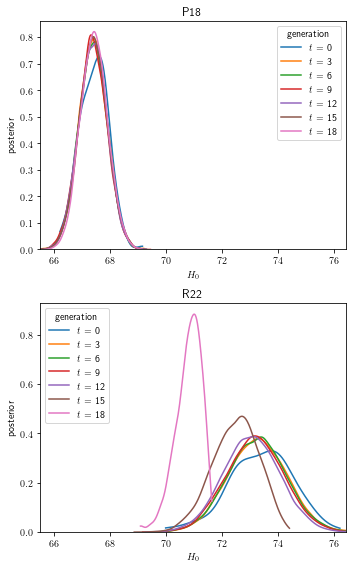

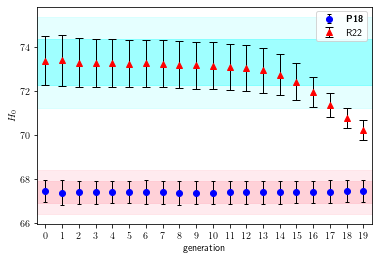

In [ ]:
def ax_set(ax, title, xlabel, ylabel, x_min, x_max, \
           legend_title, legend_loc):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(bottom = 0)
    ax.legend(title = legend_title, loc = legend_loc)

fig, axes = plt.subplots(2)
fig.set_size_inches((5, 8))
axes = axes.flatten()
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 3):
        df, w = history.get_distribution(m = m, t = t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, 'H0', ax = ax, label = f"$t$ = {t}", numx = 200)
ax_set(axes[0], 'P18', '$H_0$', 'posterior',
       67 - 0.5*3, 73.30 + 1.04*3, 'generation', 'upper right')
ax_set(axes[1], 'R22', '$H_0$', 'posterior',
       67 - 0.5*3, 73.30 + 1.04*3, 'generation', 'upper left')
fig.tight_layout()
plt.show()

# generational H0 plot
fig, ax = plt.subplots()
clst = ['b', 'r']
mlst = ['o', '^']
csze = [2, 4]
legends = [r'\textbf{P18}', 'R22']
for k in cred_int:
    i = list(cred_int.keys()).index(k)
    n_gen = len(cred_int[k]['H0'])
    t = np.arange(0, n_gen)
    l = cred_int[k]['H0']
    sigl = cred_int[k]['sigH0']
    ax.errorbar(t, l, yerr = sigl,
                fmt = clst[i] + mlst[i], 
                markersize = 6, ecolor = 'k',
                elinewidth = 1, capsize = csze[i],
                label = legends[i])

H0_P18, sigH0_P18 = 67.4, 0.5
H0_R22, sigH0_R22 = 73.30, 1.04
genspace = np.linspace(-0.5, n_gen, 100)
ax.fill_between(genspace, \
                np.array([H0_P18 - sigH0_P18]*len(genspace)), \
                np.array([H0_P18 + sigH0_P18]*len(genspace)), \
                alpha = .6, facecolor = 'pink', edgecolor = 'pink')
ax.fill_between(genspace, \
                np.array([H0_P18 - 2*sigH0_P18]*len(genspace)), \
                np.array([H0_P18 + 2*sigH0_P18]*len(genspace)), \
                alpha = .3, facecolor = 'pink', edgecolor = 'pink')
ax.fill_between(genspace, \
                np.array([H0_R22 - sigH0_R22]*len(genspace)), \
                np.array([H0_R22 + sigH0_R22]*len(genspace)), \
                alpha = .3, facecolor = 'cyan', edgecolor = 'cyan')
ax.fill_between(genspace, \
                np.array([H0_R22 - 2*sigH0_R22]*len(genspace)), \
                np.array([H0_R22 + 2*sigH0_R22]*len(genspace)), \
                alpha = .1, facecolor = 'cyan', edgecolor = 'cyan')
    
ax.legend(loc = 'upper right', prop = {'size': 9.5})
ax.set_xlabel('generation')
ax.set_ylabel(r'$H_0$')
ax.set_xlim(-0.5, n_gen - 0.5)
ax.set_xticks([x for x in range(0, n_gen)])
plt.show()

Behold, the generational evolution of the matter density.

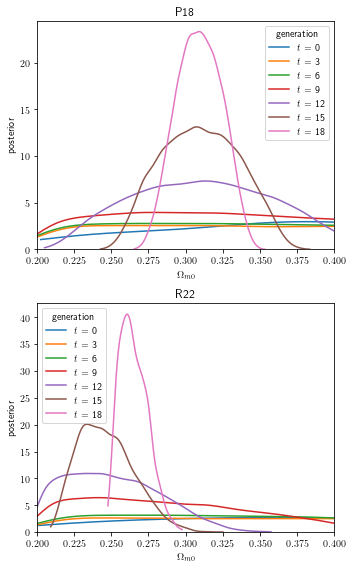

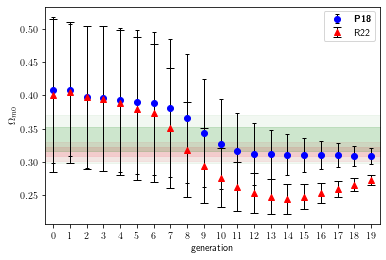

In [ ]:
fig, axes = plt.subplots(2)
fig.set_size_inches((5, 8))
axes = axes.flatten()
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 3):
        df, w = history.get_distribution(m = m, t = t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, 'Om', ax = ax, label = f"$t$ = {t}", numx = 200)
ax_set(axes[0], 'P18', '$\Omega_{m0}$', 'posterior',
       0.2, 0.4, 'generation', 'upper right')
ax_set(axes[1], 'R22', '$\Omega_{m0}$', 'posterior',
       0.2, 0.4, 'generation', 'upper left')
fig.tight_layout()
plt.show()

# generational Om plot
fig, ax = plt.subplots()
for k in cred_int:
    i = list(cred_int.keys()).index(k)
    n_gen = len(cred_int[k]['Om'])
    t = np.arange(0, n_gen)
    l = cred_int[k]['Om']
    sigl = cred_int[k]['sigOm']
    ax.errorbar(t, l, yerr = sigl,
                fmt = clst[i] + mlst[i], 
                markersize = 6, ecolor = 'k',
                elinewidth = 1, capsize = csze[i],
                label = legends[i])
    
Om_P18, sigOm_P18 = 0.3153, 0.0073
Om_loc, sigOm_loc = 0.334, 0.018# local measurements, Pantheon+ + SH0ES
ax.fill_between(genspace, \
                np.array([Om_P18 - sigOm_P18]*len(genspace)), \
                np.array([Om_P18 + sigOm_P18]*len(genspace)), \
                alpha = .6, facecolor = 'pink', edgecolor = 'pink')
ax.fill_between(genspace, \
                np.array([Om_P18 - 2*sigOm_P18]*len(genspace)), \
                np.array([Om_P18 + 2*sigOm_P18]*len(genspace)), \
                alpha = .3, facecolor = 'pink', edgecolor = 'pink')
ax.fill_between(genspace, \
                np.array([Om_loc - sigOm_loc]*len(genspace)), \
                np.array([Om_loc + sigOm_loc]*len(genspace)), \
                alpha = .15, facecolor = 'green', edgecolor = 'green')
ax.fill_between(genspace, \
                np.array([Om_loc - 2*sigOm_loc]*len(genspace)), \
                np.array([Om_loc + 2*sigOm_loc]*len(genspace)), \
                alpha = .05, facecolor = 'green', edgecolor = 'green')

ax.legend(loc = 'upper right', prop = {'size': 9.5})
ax.set_xlabel('generation')
ax.set_ylabel(r'$\Omega_{m0}$')
ax.set_xlim(-0.5, n_gen - 0.5)
ax.set_xticks([x for x in range(0, n_gen)])
plt.show()

Here is the generational evolution of the $f \sigma_8$ estimates.

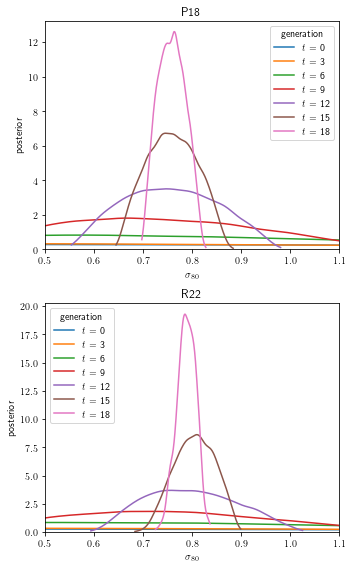

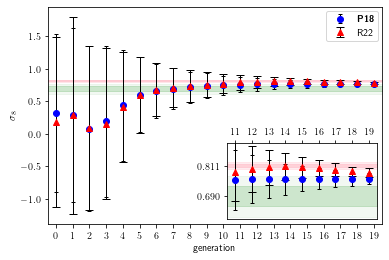

In [ ]:
fig, axes = plt.subplots(2)
fig.set_size_inches((5, 8))
axes = axes.flatten()
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 3):
        df, w = history.get_distribution(m = m, t = t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, 's80', ax = ax, label = f"$t$ = {t}", numx = 200)
ax_set(axes[0], 'P18', '$\sigma_{80}$', 'posterior',
       0.5, 1.1, 'generation', 'upper right')
ax_set(axes[1], 'R22', '$\sigma_{80}$', 'posterior',
       0.5, 1.1, 'generation', 'upper left')
fig.tight_layout()
plt.show()

# generational Om plot
fig, ax = plt.subplots()
ix = inset_axes(ax, width = '45%', height = '35%', loc = 'lower right')
for k in cred_int:
    i = list(cred_int.keys()).index(k)
    n_gen = len(cred_int[k]['s80'])
    t = np.arange(0, n_gen)
    l = cred_int[k]['s80']
    sigl = cred_int[k]['sigs80']
    ax.errorbar(t, l, yerr = sigl,
                fmt = clst[i] + mlst[i], 
                markersize = 6, ecolor = 'k',
                elinewidth = 1, capsize = csze[i],
                label = legends[i])
    ix.errorbar(t, l, yerr = sigl,
                fmt = clst[i] + mlst[i], 
                markersize = 6, ecolor = 'k',
                elinewidth = 1, capsize = csze[i],
                label = legends[i])

s80_P18, sigs80_P18 = 0.8111, 0.0060 # CMB
s80_loc, sigs80_loc = 0.69, 0.04 # galaxy clustering, arxiv:2112.04515
ax.fill_between(genspace, \
                np.array([s80_P18 - sigs80_P18]*len(genspace)), \
                np.array([s80_P18 + sigs80_P18]*len(genspace)), \
                alpha = .6, facecolor = 'pink', edgecolor = 'pink')
ax.fill_between(genspace, \
                np.array([s80_P18 - 2*sigs80_P18]*len(genspace)), \
                np.array([s80_P18 + 2*sigs80_P18]*len(genspace)), \
                alpha = .3, facecolor = 'pink', edgecolor = 'pink')
ax.fill_between(genspace, \
                np.array([s80_loc - sigs80_loc]*len(genspace)), \
                np.array([s80_loc + sigs80_loc]*len(genspace)), \
                alpha = .15, facecolor = 'green', edgecolor = 'green')
ax.fill_between(genspace, \
                np.array([s80_loc - 2*sigs80_loc]*len(genspace)), \
                np.array([s80_loc + 2*sigs80_loc]*len(genspace)), \
                alpha = .05, facecolor = 'green', edgecolor = 'green')
# for the inset
ix.fill_between(genspace, \
                np.array([s80_P18 - sigs80_P18]*len(genspace)), \
                np.array([s80_P18 + sigs80_P18]*len(genspace)), \
                alpha = .6, facecolor = 'pink', edgecolor = 'pink')
ix.fill_between(genspace, \
                np.array([s80_P18 - 2*sigs80_P18]*len(genspace)), \
                np.array([s80_P18 + 2*sigs80_P18]*len(genspace)), \
                alpha = .3, facecolor = 'pink', edgecolor = 'pink')
ix.fill_between(genspace, \
                np.array([s80_loc - sigs80_loc]*len(genspace)), \
                np.array([s80_loc + sigs80_loc]*len(genspace)), \
                alpha = .15, facecolor = 'green', edgecolor = 'green')
ix.fill_between(genspace, \
                np.array([s80_loc - 2*sigs80_loc]*len(genspace)), \
                np.array([s80_loc + 2*sigs80_loc]*len(genspace)), \
                alpha = .05, facecolor = 'green', edgecolor = 'green')
ax.legend(loc = 'upper right', prop = {'size': 9.5})
ax.set_xlabel('generation')
ax.set_ylabel(r'$\sigma_{8}$')
ax.set_xlim(-0.5, n_gen - 0.5)
ax.set_xticks([x for x in range(0, n_gen)])
ix.xaxis.tick_top()
ix.set_xlim(11 - 0.5, n_gen - 0.5)
ix.set_xticks(np.arange(11, n_gen, 1))
ix.set_ylim(0.6, 0.9)
ix.set_yticks([s80_P18, s80_loc])
plt.show()

And lastly, the generational evolution of the supernovae absolute magnitude.

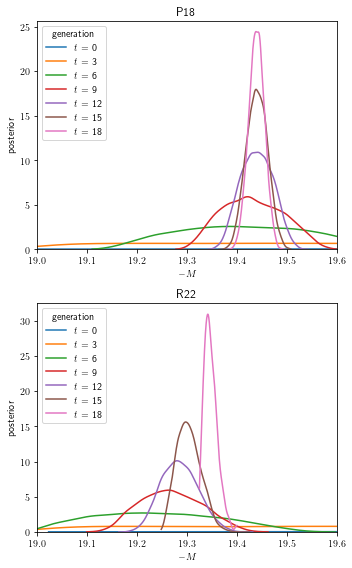

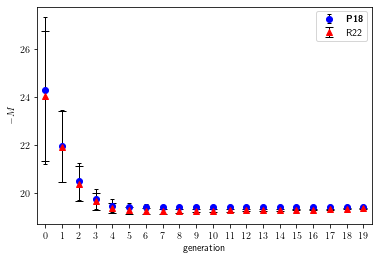

In [ ]:
fig, axes = plt.subplots(2)
fig.set_size_inches((5, 8))
axes = axes.flatten()
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 3):
        df, w = history.get_distribution(m = m, t = t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, 'M', ax = ax, label = f"$t$ = {t}", numx = 200)
ax_set(axes[0], 'P18', '$-M$', 'posterior', 19.0, 19.6, 'generation', 'upper left')
ax_set(axes[1], 'R22', '$-M$', 'posterior', 19.0, 19.6, 'generation', 'upper left')
fig.tight_layout()
plt.show()

# generational M plot
fig, ax = plt.subplots()
for k in cred_int:
    i = list(cred_int.keys()).index(k)
    n_gen = len(cred_int[k]['M'])
    t = np.arange(0, n_gen)
    l = cred_int[k]['M']
    sigl = cred_int[k]['sigM']
    ax.errorbar(t, l, yerr = sigl,
                fmt = clst[i] + mlst[i], 
                markersize = 6, ecolor = 'k',
                elinewidth = 1, capsize = csze[i],
                label = legends[i])
    
ax.legend(loc = 'upper right', prop = {'size': 9.5})
ax.set_xlabel('generation')
ax.set_ylabel(r'$-M$')
ax.set_xlim(-0.5, n_gen - 0.5)
ax.set_xticks([x for x in range(0, n_gen)])
plt.show()

We could also take a look at the best fit curves for each model. We take the last surviving population estimate for the R22.

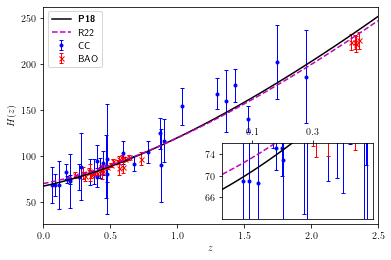

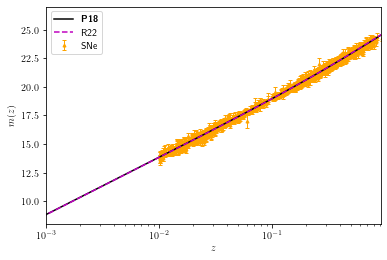

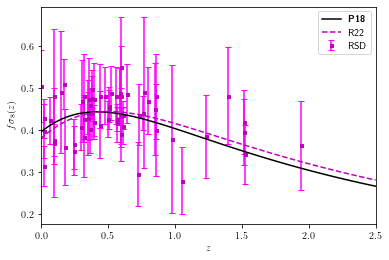

In [ ]:
# P18 best fit
zbf = np.linspace(1e-5, 2.5, 100)
HzP18bf = last_pop['P18']['H0']*E(zbf, last_pop['P18']['Om'])
mzP18bf = np.array([mu(z, last_pop['P18']['Om'], last_pop['P18']['H0']) \
                    - last_pop['P18']['M'] for z in zbf])
fs8zP18bf = fs8(zbf, last_pop['P18']['Om'], last_pop['P18']['s80'])

# R22 best fit
HzR22bf = last_pop['R22']['H0']*E(zbf, last_pop['R22']['Om'])
mzR22bf = np.array([mu(z, last_pop['R22']['Om'], last_pop['R22']['H0']) \
                    - last_pop['R22']['M'] for z in zbf])
fs8zR22bf = fs8(zbf, last_pop['R22']['Om'], last_pop['R22']['s80'])

fig, ax = plt.subplots()
ix = inset_axes(ax, width = '45%', height = '35%', loc = 'lower right')
ax.plot(zbf, HzP18bf, 'k-', label = r'\textbf{P18}')
ax.plot(zbf, HzR22bf, 'm--', label = r'R22')
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'bo', ecolor = 'b', \
            markersize = 3, elinewidth = 1, capsize = 2, label = 'CC', zorder = 0)
ax.errorbar(z_bao, Hz_bao, yerr = sigHz_bao, fmt = 'rx', ecolor = 'red', \
            markersize = 5, elinewidth = 1, capsize = 2, label = 'BAO', zorder = 0)
ix.plot(zbf, HzP18bf, 'k-')
ix.plot(zbf, HzR22bf, 'm--')
ix.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'bo', ecolor = 'b', \
            markersize = 3, elinewidth = 1, capsize = 2, zorder = 0)
ix.errorbar(z_bao, Hz_bao, yerr = sigHz_bao, fmt = 'rx', ecolor = 'red', \
            markersize = 5, elinewidth = 1, capsize = 2, zorder = 0)

ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
ax.set_xlim(0, 2.5)
ax.legend(loc = 'upper left', prop = {'size': 9.5})
ix.xaxis.tick_top()
ix.set_xlim(0.00, 0.5)
ix.set_xticks([0.1, 0.3])
ix.set_ylim(62, 76)
ix.set_yticks([66, 70, 74])
ix.xaxis.set_tick_params(labelsize = 10)
ix.yaxis.set_tick_params(labelsize = 10)
plt.show()

# apparent magnitudes
fig, ax = plt.subplots()
ax.plot(zbf, mzP18bf, 'k-', label = r'\textbf{P18}')
ax.plot(zbf, mzR22bf, 'm--', label = 'R22')
ax.errorbar(z_pp, mz_pp, yerr = sigmz_pp, \
            fmt = '^', color = 'orange', markersize = 3, \
            ecolor = 'orange', elinewidth = 1, capsize = 2, \
            label = 'SNe', zorder = 0)
ax.set_xscale('log')
ax.set_xlabel('$z$')
ax.set_ylabel('$m(z)$')
ax.set_xlim(1e-3, np.log(max(zbf)))
ax.set_ylim(8, 27)
ax.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

# growth data
fig, ax = plt.subplots()
ax.plot(zbf, fs8zP18bf, 'k-', label = r'\textbf{P18}')
ax.plot(zbf, fs8zR22bf, 'm--', label = 'R22')
ax.errorbar(z_rsd, fs8_rsd, yerr = sigfs8_rsd, fmt = 'ms', \
            ecolor = 'magenta', markersize = 3, elinewidth = 1.5, \
            capsize = 3, label = 'RSD', zorder = 0)
ax.set_xlabel('$z$')
ax.set_ylabel('$f \sigma_8(z)$')
ax.set_xlim(0, 2.5)
ax.legend(loc = 'upper right', prop = {'size': 9.5})
plt.show()